<a href="https://colab.research.google.com/github/runqingz/CSC2515YOLOPedestrianDetection/blob/main/Yolor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install lxml
!pip install tqdm

**Unzip Data.zip**

In [80]:
from zipfile import ZipFile
file_name = "/content/Data.zip"

with ZipFile(file_name, 'r') as zipfile:
  zipfile.extractall()
  print('Done')
%reset

Done
Once deleted, variables cannot be recovered. Proceed (y/[n])? n
Nothing done.


In [3]:
from lxml import etree as ET
import os
from tqdm import tqdm
import random
from IPython.display import Image
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt
import shutil

**Helper Function 1: Convert XML to YOLO info dict**

In [4]:
# Function to get the data from XML Annotation


def extract_info_from_xml(xml_file):
    root = ET.parse(xml_file).getroot()
    
    # Initialise the info dict 
    info_dict = {}
    info_dict['bboxes'] = []

    # Parse the XML Tree
    for elem in root:
        # Get the file name 
        if elem.tag == "filename":
            info_dict['filename'] = elem.text
            
        # Get the image size
        elif elem.tag == "size":
            image_size = []
            for subelem in elem:
                image_size.append(int(subelem.text))
            
            info_dict['image_size'] = tuple(image_size)
        
        # Get details of the bounding box 
        elif elem.tag == "object":
            bbox = {}
            for subelem in elem:
                if subelem.tag == "name":
                    bbox["class"] = subelem.text
                    
                elif subelem.tag == "bndbox":
                    for subsubelem in subelem:
                        bbox[subsubelem.tag] = int(float(subsubelem.text))           
            info_dict['bboxes'].append(bbox)
    
    return info_dict

**Test Helper Function 1**

In [6]:
print(extract_info_from_xml("/content/Data/Labels/set00/set00-occ_1.xml"))

{'bboxes': [{'class': 'person', 'xmin': 46, 'ymin': 121, 'xmax': 172, 'ymax': 415}, {'class': 'person', 'xmin': 508, 'ymin': 166, 'xmax': 525, 'ymax': 216}, {'class': 'person', 'xmin': 432, 'ymin': 94, 'xmax': 543, 'ymax': 400}, {'class': 'person', 'xmin': 485, 'ymin': 162, 'xmax': 503, 'ymax': 215}, {'class': 'person', 'xmin': 585, 'ymin': 167, 'xmax': 602, 'ymax': 218}, {'class': 'person', 'xmin': 390, 'ymin': 117, 'xmax': 506, 'ymax': 353}], 'filename': 'set00-occ_1.jpg', 'image_size': (640, 480, 3)}


**Save the info dict to YOLO style and save to txt file**


In [81]:
# Dictionary that maps class names to IDs
class_name_to_id_mapping = {"person": 0}

# Convert the info dict to the required yolo format and write it to disk
def convert_to_yolor(info_dict, output_path):
    print_buffer = []

    if not os.path.exists(output_path):
        os.makedirs(output_path)
    
    # For each bounding box
    for b in info_dict["bboxes"]:
        try:
            class_id = class_name_to_id_mapping[b["class"]]
        except KeyError:
            print("Invalid Class. Must be one from ", class_name_to_id_mapping.keys())
        
        # Transform the bbox co-ordinates as per the format required by YOLO v5
        b_center_x = (b["xmin"] + b["xmax"]) / 2 
        b_center_y = (b["ymin"] + b["ymax"]) / 2
        b_width    = (b["xmax"] - b["xmin"])
        b_height   = (b["ymax"] - b["ymin"])
        
        # Normalise the co-ordinates by the dimensions of the image
        image_w, image_h, image_c = info_dict["image_size"]  
        b_center_x /= image_w 
        b_center_y /= image_h 
        b_width    /= image_w 
        b_height   /= image_h 
        
        #Write the bbox details to the file 
        print_buffer.append("{} {:.3f} {:.3f} {:.3f} {:.3f}".format(class_id, b_center_x, b_center_y, b_width, b_height))
        
    # Name of the file which we have to save 
    save_file_name = os.path.join(output_path, info_dict["filename"].replace("jpg", "txt"))
    
    # Save the annotation to disk
    print("\n".join(print_buffer), file= open(save_file_name, "w+"))

**Convert all XMLs**

In [82]:


input_path = '/content/Data/Labels'
output_path = '/content/Data/Labels/Yolo'

# Get the annotations
sub_dirs = os.listdir(input_path)
annotations = []
for sub_dir in sub_dirs:
    set_path = os.path.join(input_path, sub_dir)
    outset_path = os.path.join(output_path, sub_dir)

    if not os.path.exists(outset_path):
        os.makedirs(outset_path)

    annotation = [os.path.join(set_path, x) for x in os.listdir(set_path) if x[-3:] == "xml"]
    for ann in annotation:
        info_dict = extract_info_from_xml(ann)
        convert_to_yolor(info_dict, outset_path)
    annotations = annotations + [os.path.join(outset_path, x) for x in os.listdir(outset_path) if x[-3:] == "txt"]

annotations.sort()
print(annotations)

['/content/Data/Labels/Yolo/set00/set00-occ_1.txt', '/content/Data/Labels/Yolo/set00/set00-occ_10.txt', '/content/Data/Labels/Yolo/set00/set00-occ_100.txt', '/content/Data/Labels/Yolo/set00/set00-occ_101.txt', '/content/Data/Labels/Yolo/set00/set00-occ_102.txt', '/content/Data/Labels/Yolo/set00/set00-occ_103.txt', '/content/Data/Labels/Yolo/set00/set00-occ_104.txt', '/content/Data/Labels/Yolo/set00/set00-occ_105.txt', '/content/Data/Labels/Yolo/set00/set00-occ_11.txt', '/content/Data/Labels/Yolo/set00/set00-occ_12.txt', '/content/Data/Labels/Yolo/set00/set00-occ_13.txt', '/content/Data/Labels/Yolo/set00/set00-occ_14.txt', '/content/Data/Labels/Yolo/set00/set00-occ_15.txt', '/content/Data/Labels/Yolo/set00/set00-occ_16.txt', '/content/Data/Labels/Yolo/set00/set00-occ_17.txt', '/content/Data/Labels/Yolo/set00/set00-occ_18.txt', '/content/Data/Labels/Yolo/set00/set00-occ_19.txt', '/content/Data/Labels/Yolo/set00/set00-occ_2.txt', '/content/Data/Labels/Yolo/set00/set00-occ_20.txt', '/conte

**Test drawing bounding box on images**

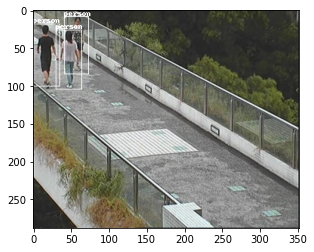

In [97]:


image_path = '/content/Data/Images'

class_id_to_name_mapping = (dict(zip(class_name_to_id_mapping.values(), class_name_to_id_mapping.keys())))

def plot_bounding_box(image, annotation_list):
    annotations = np.array(annotation_list)
    w, h = image.size
    
    plotted_image = ImageDraw.Draw(image)

    transformed_annotations = np.copy(annotations)
    transformed_annotations[:,[1,3]] = annotations[:,[1,3]] * w
    transformed_annotations[:,[2,4]] = annotations[:,[2,4]] * h 
    
    transformed_annotations[:,1] = transformed_annotations[:,1] - (transformed_annotations[:,3] / 2)
    transformed_annotations[:,2] = transformed_annotations[:,2] - (transformed_annotations[:,4] / 2)
    transformed_annotations[:,3] = transformed_annotations[:,1] + transformed_annotations[:,3]
    transformed_annotations[:,4] = transformed_annotations[:,2] + transformed_annotations[:,4]
    
    for ann in transformed_annotations:
        obj_cls, x0, y0, x1, y1 = ann
        plotted_image.rectangle(((x0,y0), (x1,y1)))
        
        plotted_image.text((x0, y0 - 10), class_id_to_name_mapping[(int(obj_cls))])
    
    plt.imshow(np.array(image))
    plt.show()

# Get any random annotation file 
annotation_file = random.choice(annotations)
with open(annotation_file, "r") as file:
    annotation_list = file.read().split("\n")[:-1]
    annotation_list = [x.split(" ") for x in annotation_list]
    annotation_list = [[float(y) for y in x ] for x in annotation_list]

#Get the corresponding image file
label_file_name = os.path.basename(annotation_file)

image_file_token = label_file_name.split('-')
image_dir = image_file_token[0]

image_file = os.path.join(image_path, image_dir,label_file_name.replace("txt", "jpg"))

#print(image_file)
assert os.path.exists(image_file)

#Load the image
image = Image.open(image_file)

#Plot the Bounding Box
plot_bounding_box(image, annotation_list)

**Load train/val/test data file**

In [78]:
#Utility function to move images 
def move_files_to_folder(list_of_files, dst_dir):
    for file in list_of_files:
        try:
            shutil.move(file, dst_dir)
        except:
            print(src)
            assert False


In [74]:
!mkdir /content/Data/YOLO
!mkdir /content/Data/YOLO/images /content/Data/YOLO/labels
!mkdir /content/Data/YOLO/images/train /content/Data/YOLO/images/val /content/Data/YOLO/images/test /content/Data/YOLO/labels/train /content/Data/YOLO/labels/val /content/Data/YOLO/labels/test

In [79]:
# Read images and annotations
image_src_dir = '/content/Data/Images'
image_dst_dir = '/content/Data/YOLO/images'

label_src_dir = '/content/Data/Labels/Yolo'
label_dst_dir = '/content/Data/YOLO/labels'

train_sets = ['set00', 'set01', 'set02', 'set03','set04','set05','set06']
val_sets = ['set07']
test_sets = ['set08']

for train_set in train_sets:
    train_images = [os.path.join(image_src_dir, train_set, x) for x in os.listdir(os.path.join(image_src_dir, train_set))]
    move_files_to_folder(train_images, os.path.join(image_dst_dir, 'train'))
    train_labels = [os.path.join(label_src_dir, train_set, x) for x in os.listdir(os.path.join(label_src_dir, train_set))]
    move_files_to_folder(train_labels, os.path.join(label_dst_dir, 'train'))

for val_set in val_sets:
    train_images = [os.path.join(image_src_dir, val_set, x) for x in os.listdir(os.path.join(image_src_dir, val_set))]
    move_files_to_folder(train_images, os.path.join(image_dst_dir, 'val'))
    train_labels = [os.path.join(label_src_dir, val_set, x) for x in os.listdir(os.path.join(label_src_dir, val_set))]
    move_files_to_folder(train_labels, os.path.join(label_dst_dir, 'val'))

for test_set in test_sets:
    train_images = [os.path.join(image_src_dir, test_set, x) for x in os.listdir(os.path.join(image_src_dir, test_set))]
    move_files_to_folder(train_images, os.path.join(image_dst_dir, 'test'))
    train_labels = [os.path.join(label_src_dir, test_set, x) for x in os.listdir(os.path.join(label_src_dir, test_set))]
    move_files_to_folder(train_labels, os.path.join(label_dst_dir, 'test'))


**Move data to corresponding folders**